In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Calculate moving averages
def moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

In [99]:
# Calculate momentum
def momentum(data, window):
    return data['Close'].diff(window - 1)

In [100]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()

    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [101]:
def adx(data, window=14):

    # Calculate True Range
    data['tr0'] = abs(data['High'] - data['Low'])
    data['tr1'] = abs(data['High'] - data['Close'].shift())
    data['tr2'] = abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['tr0', 'tr1', 'tr2']].max(axis=1)

    # Calculate Directional Movement
    data['DMplus'] = np.where((data['High'] - data['High'].shift()) > (data['Low'].shift() - data['Low']), data['High'] - data['High'].shift(), 0)
    data['DMminus'] = np.where((data['Low'].shift() - data['Low']) > (data['High'] - data['High'].shift()), data['Low'].shift() - data['Low'], 0)

    # Calculate Smoothed True Range
    data['ATR'] = data['TR'].rolling(window=window).mean()

    # Calculate Smoothed Directional Movement
    data['ADMplus'] = data['DMplus'].rolling(window=window).mean()
    data['ADMminus'] = data['DMminus'].rolling(window=window).mean()

    # Calculate Directional Index
    data['DIplus'] = (data['ADMplus'] / data['ATR']) * 100
    data['DIminus'] = (data['ADMminus'] / data['ATR']) * 100

    data['DX'] = abs(data['DIplus'] - data['DIminus']) / (data['DIplus'] + data['DIminus']) * 100

    adx_values = data['DX'].rolling(window=window).mean()

    return (adx_values, data['DIplus'], data['DIminus'])

In [102]:
# Trading strategy combining moving average crossover, momentum, and VWAP
def trading_strategy(data, rsi_window=None, overbought_threshold=None, oversold_threshold=None, adx_window=None, adx_threshold=None, short_window=None, long_window=None, momentum_window=None):
    signals = pd.DataFrame(index=data.index)
    signals['Date'] = pd.to_datetime(data['Date'])
    signals['signal'] = 0.0

    # Moving average crossover
    if short_window:
        signals['short_mavg'] = moving_average(data, short_window)
        signals['long_mavg'] = moving_average(data, long_window)
        signals['signal'] = 0.0
        # Place buy order when short moving average crosses above long moving average
        signals.loc[(signals['short_mavg'].shift(1) < signals['long_mavg'].shift(1)) & (signals['short_mavg'] > signals['long_mavg']), 'signal'] = 1.0

        # Place sell order when short moving average crosses below long moving average
        signals.loc[(signals['short_mavg'].shift(1) > signals['long_mavg'].shift(1)) & (signals['short_mavg'] < signals['long_mavg']), 'signal'] = -1.0

    # Momentum
    if momentum_window:
        signals['momentum'] = momentum(data, momentum_window)
        signals.loc[(signals['momentum'] > 0), 'signal'] = 1.0
        signals.loc[(signals['momentum'] < 0), 'signal'] = -1.0
        
        
    if rsi_window:
        rsi_values = calculate_rsi(data, window=rsi_window)
        signals['rsi'] = rsi_values
        signals.loc[signals['rsi'] > overbought_threshold, 'signal'] = -1.0
        signals.loc[signals['rsi'] < oversold_threshold, 'signal'] = 1.0

    if adx_window:
        #### if +DI crosses over -DI create a buy signal and vice-a-versa
        adx_values = adx(data, window=adx_window)
        signals['adx'] = adx_values[0]
        signals['+DI'] = adx_values[1]
        signals['-DI'] = adx_values[2]
        signals.loc[(signals['+DI'].shift(1) < signals['-DI'].shift(1)) & (signals['+DI'] > signals['-DI']) & (signals['adx'] > adx_threshold), 'signal'] = 1.0
    
        # Place sell signal when -DI crosses over +DI and ADX is above the threshold
        signals.loc[(signals['+DI'].shift(1) > signals['-DI'].shift(1)) & (signals['+DI'] < signals['-DI']) & (signals['adx'] > adx_threshold), 'signal'] = -1.0
        
        
    return signals

In [110]:
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2019-01-01']

In [111]:
# signals = trading_strategy(df, short_window=20, long_window=70)
#signals = trading_strategy(df, adx_window=14, adx_threshold=25)
signals = trading_strategy(df, rsi_window=14, overbought_threshold=80, oversold_threshold=40)
# signals = trading_strategy(df, momentum_window=5)
signals.to_csv("MSFT_signal.csv")
signals = trading_strategy(df, momentum_window=5)
signals.to_csv("MSFT__momentum_signal.csv")
signals = trading_strategy(df, short_window=10, long_window=30, momentum_window=5, adx_window=14, adx_threshold=25, rsi_window=14, overbought_threshold=80, oversold_threshold=40)
signals.to_csv("MSFT_complete_signal.csv")

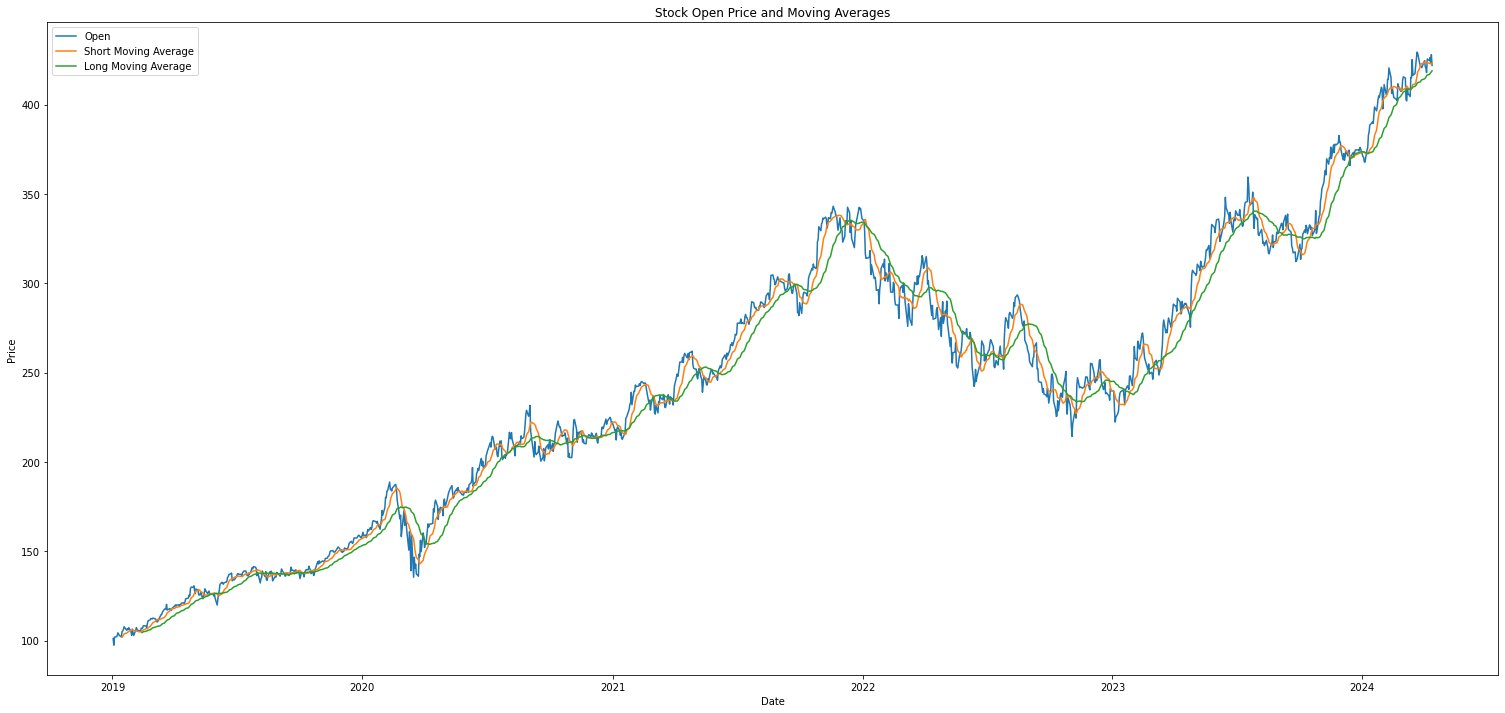

In [112]:
# Plotting the graph
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['short_mavg'].values, label='Short Moving Average')
plt.plot(signals['Date'].values, signals['long_mavg'].values, label='Long Moving Average')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

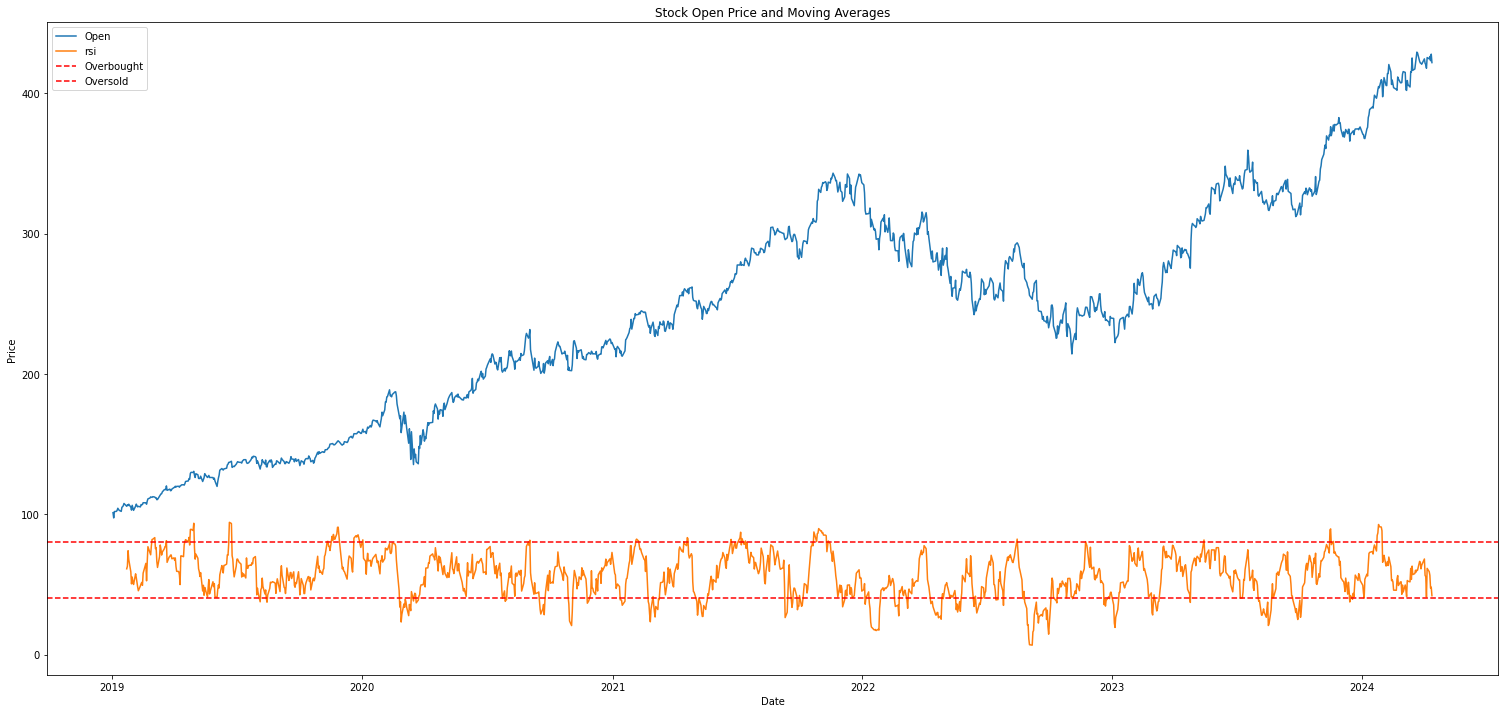

In [113]:
# Plotting the graph
plt.figure(figsize=(26, 12))
plt.plot(signals['Date'].values, df['Close'].values, label='Open')
plt.plot(signals['Date'].values, signals['rsi'].values, label='rsi')
plt.axhline(y=80, color='r', linestyle='--', label='Overbought')
plt.axhline(y=40, color='r', linestyle='--', label='Oversold')
plt.title('Stock Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

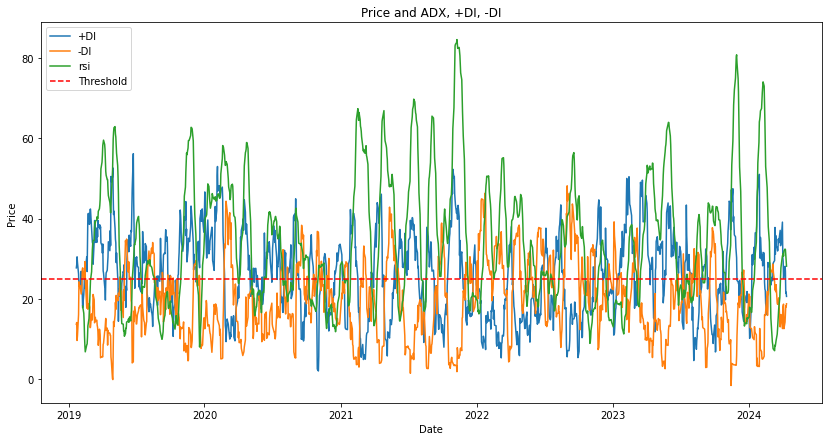

In [114]:
plt.figure(figsize=(14, 7))
plt.plot(signals['Date'].values, signals['+DI'].values, label='+DI')
plt.plot(signals['Date'].values, signals['-DI'].values, label='-DI')
plt.plot(signals['Date'].values, signals['adx'].values, label='rsi')
plt.axhline(y=25, color='r', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and ADX, +DI, -DI')
plt.legend()
plt.show()

In [126]:

def backtest_strategy(data, initial_cash, position_size, transaction_cost, stop_loss, take_profit, **kwargs):
    signals = trading_strategy(data, **kwargs)

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['Cash'] = initial_cash
    portfolio['Position'] = 0.0
    portfolio['pnl'] = 0
    portfolio['g_sl'] = 0
    portfolio['g_tp'] = 0
    portfolio['close'] = 0
    global sl, tp, buy, sell, amount, pnl, no_trades, no_wins
    sl = 0
    tp = 0
    buy = False
    sell = False
    pnl = 0
    amount = 0
    no_trades = 0
    no_wins = 0
    
    cash_balance = initial_cash  # Initialize cash balance
    
    for index, row in signals.iterrows():
        signal = row['signal']
        price = data.loc[index, 'Close']
        stop_loss_price = price - stop_loss
        take_profit_price = price + take_profit
        
        # Calculate transaction cost
        cost = abs(signal - portfolio['Position'].iloc[-1]) * price * position_size * transaction_cost
        
        if signal == 1.0 and cash_balance >= price * position_size and tp == 0:
            # Buy
            portfolio.loc[index, 'Position'] = position_size
            cash_balance -= price * position_size + cost
            tp = take_profit_price
            sl = stop_loss_price
            amount = price * position_size
            buy = True
        elif signal == -1.0 and cash_balance >= price * position_size and tp == 0:
            # Sell
            portfolio.loc[index, 'Position'] = -position_size
            cash_balance -= price * position_size - cost
            tp = stop_loss_price
            sl = take_profit_price
            amount = price * position_size
            sell = True
        
        if price >= tp and buy:
            cash_balance += amount + (take_profit * position_size)
            tp = 0
            sl = 0
            buy = False
            pnl += (take_profit * position_size)
            no_trades += 1
            no_wins += 1
        if price <= sl and buy:
            cash_balance += amount - (stop_loss * position_size)
            tp = 0
            sl = 0
            buy = False
            pnl -= (stop_loss * position_size)
            no_trades += 1
        if price <= tp and sell:
            cash_balance += amount + (take_profit * position_size)
            tp = 0
            sl = 0
            sell = False
            pnl += (take_profit * position_size)
            no_trades += 1
            no_wins += 1
        if price >= sl and sell:
            cash_balance += amount - (stop_loss * position_size)
            tp = 0
            sl = 0
            sell = False
            pnl -= (stop_loss * position_size)
            no_trades += 1
        
        if index == signals.index[-1] and (signal == 1.0 or signal == -1.0):
            cash_balance += price * position_size
        
        # Update portfolio value
        portfolio.loc[index, 'Cash'] = int(cash_balance)
        portfolio.loc[index, 'pnl'] = int(pnl)
        portfolio.loc[index, 'g_sl'] = int(sl)
        portfolio.loc[index, 'g_tp'] = int(tp)
        portfolio.loc[index, 'close'] = int(price)
        portfolio.loc[index, 'no_trades'] = int(no_trades)
        portfolio.loc[index, 'no_wins'] = int(no_wins)

    sl = 0
    tp = 0
    pnl = 0
    amount = 0

    return portfolio

In [133]:
# Microsoft
df = pd.read_csv("MSFT_hist.csv")
df = df[df['Date'] >= '2019-01-01']

print("Microsoft")
print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))

portfolio.to_csv("MSFT_portfolio.csv")

Microsoft

Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 8.0 , No-Trades: 56.0  Win%: 51.79
Short-Window: 10, Long-Window: 30, Total Profit/Loss: -12.0 , No-Trades: 49.0  Win%: 46.94
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -8.0 , No-Trades: 32.0  Win%: 46.88
Short-Window: 20, Long-Window: 30, Total Profit/Loss: 12.0 , No-Trades: 41.0  Win%: 53.66
Short-Window: 20, Long-Window: 50, Total Profit/Loss: -20.0 , No-Trades: 25.0  Win%: 40.0
Short-Window: 20, Long-Window: 70, Total Profit/Loss: 28.0 , No-Trades: 15.0  Win%: 73.33
Short-Window: 20, Long-Window: 100, Total Profit/Loss: 16.0 , No-Trades: 8.0  Win%: 75.0

ADX:
ADX-Window: 4, ADX-Threshold: 50, Total Profit/Loss: -84.0 , No-Trades: 97.0  Win%: 39.18
ADX-Window: 4, ADX-Threshold: 75, Total Profit/Loss: -32.0 , No-Trades: 26.0  Win%: 34.62
ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss: -32.0 , No-Trades: 112.0  Win%: 46.43
ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss: -4.0 , No-Trad

/var/folders/w8/zv2y__2j6k11ky_33gwp9_j80000gn/T/ipykernel_1422/1139645209.py:38: RuntimeWarning: invalid value encountered in scalar divide
  print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))


ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss: 0.0 , No-Trades: 0.0  Win%: nan
ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss: 0.0 , No-Trades: 44.0  Win%: 50.0
ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss: 8.0 , No-Trades: 6.0  Win%: 66.67


/var/folders/w8/zv2y__2j6k11ky_33gwp9_j80000gn/T/ipykernel_1422/1139645209.py:44: RuntimeWarning: invalid value encountered in scalar divide
  print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))


ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss: 0.0 , No-Trades: 0.0  Win%: nan
ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss: 8.0 , No-Trades: 28.0  Win%: 53.57
ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss: 8.0 , No-Trades: 4.0  Win%: 75.0


/var/folders/w8/zv2y__2j6k11ky_33gwp9_j80000gn/T/ipykernel_1422/1139645209.py:50: RuntimeWarning: invalid value encountered in scalar divide
  print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades']," Win%:",round(((portfolio.iloc[-1]['no_wins']/portfolio.iloc[-1]['no_trades'])*100),2))


ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss: 0.0 , No-Trades: 0.0  Win%: nan

RSI:
RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss: -12.0 , No-Trades: 193.0  Win%: 49.22
RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss: -12.0 , No-Trades: 143.0  Win%: 48.95
RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss: 48.0 , No-Trades: 110.0  Win%: 55.45
RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss: 76.0 , No-Trades: 261.0  Win%: 53.64
RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss: 68.0 , No-Trades: 215.0  Win%: 53.95
RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss: 136.0 , No-Trades: 186.0  Win%: 59.14
RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss: 64.0 , No-Trades: 306.0  Win%: 52.61
RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss: 68.0 , No-Trades: 271.0  Win%: 53.14
RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss: 100.0 , No-Trades: 247.0

In [93]:
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=1000, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 1000, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

RSI-Window: 1000, Overbought: 90, Oversold: 60, Total Profit/Loss: 132.0 , No-Trades: 98.0


In [109]:
# Apple
df = pd.read_csv("AAPL_hist.csv")
df = df[df['Date'] >= '2015-01-01']

print("\nMoving Average:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=20, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 20, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=10, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 10, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=30, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 30, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=50, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=70, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 70, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, short_window=20, long_window=100, stop_loss=4, take_profit=4)
print("Short-Window: 20, Long-Window: 100, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

print("\nADX:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=4, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 4, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=6, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=10, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 10, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=14, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 14, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=25, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 25, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=50, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, adx_window=18, adx_threshold=75, stop_loss=4, take_profit=4)
print("ADX-Window: 18, ADX-Threshold: 75, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

print("\nRSI:")
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=10, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 10, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=14, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 14, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=40, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 40, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=50, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 50, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=70, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 70, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=80, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 80, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=18, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 18, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=26, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 26, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=45, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 45, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=70, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 70, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])

portfolio = backtest_strategy(df, initial_cash=10000, position_size=1, transaction_cost=0, rsi_window=100, overbought_threshold=90, oversold_threshold=60, stop_loss=4, take_profit=4)
print("RSI-Window: 100, Overbought: 90, Oversold: 60, Total Profit/Loss:",portfolio.iloc[-1]['pnl'], ", No-Trades:",portfolio.iloc[-1]['no_trades'])
portfolio.to_csv("AAPL_portfolio.csv")


Moving Average:
Short-Window: 10, Long-Window: 20, Total Profit/Loss: 4.0 , No-Trades: 55.0
Short-Window: 10, Long-Window: 30, Total Profit/Loss: 16.0 , No-Trades: 44.0
Short-Window: 10, Long-Window: 50, Total Profit/Loss: -32.0 , No-Trades: 38.0
Short-Window: 20, Long-Window: 30, Total Profit/Loss: -20.0 , No-Trades: 47.0
Short-Window: 20, Long-Window: 50, Total Profit/Loss: 8.0 , No-Trades: 34.0
Short-Window: 20, Long-Window: 70, Total Profit/Loss: 16.0 , No-Trades: 32.0
Short-Window: 20, Long-Window: 100, Total Profit/Loss: 4.0 , No-Trades: 25.0

ADX:
ADX-Window: 4, ADX-Threshold: 25, Total Profit/Loss: -32.0 , No-Trades: 115.0
ADX-Window: 6, ADX-Threshold: 25, Total Profit/Loss: -40.0 , No-Trades: 86.0
ADX-Window: 6, ADX-Threshold: 50, Total Profit/Loss: 0.0 , No-Trades: 54.0
ADX-Window: 6, ADX-Threshold: 75, Total Profit/Loss: 0.0 , No-Trades: 10.0
ADX-Window: 10, ADX-Threshold: 25, Total Profit/Loss: 12.0 , No-Trades: 63.0
ADX-Window: 10, ADX-Threshold: 50, Total Profit/Loss: -4